In [194]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from shapely import geometry
from tqdm import tqdm
import random
import torch

In [195]:
n = 8

pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))
rnd_coef = [0.1, 0.1, 0.1]
min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])

In [196]:

def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]



In [197]:


def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area

def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])

def func(patterns):
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s


In [198]:

def get_neighbors(solution):
    neighbors = []
    n = len(solution)
    for _ in range(10):  # 10 соседей каждый раз
        neighbor = list(solution)
        # случайно выбираем индекс для мутации
        idx = random.randint(0, n - 1)
        old_coord = neighbor[idx]
        # новый набор координат с небольшим случайным смещением
        new_coord = (
            max(min_bound[0], min(old_coord[0] + random.uniform(-rnd_coef[0], rnd_coef[0]), max_bound[0])),
            max(min_bound[1], min(old_coord[1] + random.uniform(-rnd_coef[1], rnd_coef[1]), max_bound[1])),
            max(min_bound[2], min(old_coord[2] + random.uniform(-rnd_coef[2], rnd_coef[2]), max_bound[2])),
        )
        neighbor[idx] = new_coord
        neighbors.append(tuple(neighbor))
    return neighbors

def tabu_search(initial_solution, max_iterations, tabu_list_size):
    current_solution = initial_solution
    best_solution = initial_solution
    tabu_list = []

    for _ in tqdm(range(max_iterations)):
        neighbors = get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                fitness = func(neighbor)
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness

        if best_neighbor is None:
            break

        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)

        if func(current_solution) < func(best_solution):
            best_solution = current_solution

    return best_solution

# Инициализация: n наборов координат
n = 8
initial_solution = []
for _ in range(n):
    initial_solution.append((
        random.uniform(min_bound[0], max_bound[0]),
        random.uniform(min_bound[1], max_bound[1]),
        random.uniform(min_bound[2], max_bound[2])
    ))
initial_solution = tuple(initial_solution)  # чтоб была хешируемой для табу-листа

max_iterations = 1000
tabu_list_size = 10

best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size)

print("Best solution:", best_solution)
print("Best fitness:", func(best_solution))


100%|██████████| 1000/1000 [01:02<00:00, 16.08it/s]

Best solution: ((np.float64(0.4982476139371513), np.float64(1.0090475313071157), np.float64(0.026668801443829326)), (np.float64(1.0177620833132681), np.float64(1.0164534072975777), np.float64(4.681158753123353)), (np.float64(1.0035566845564186), np.float64(0.4985915987142757), np.float64(4.705020199284132)), (np.float64(1.0100976663418413), np.float64(1.5509958359355593), np.float64(4.645972306230236)), (np.float64(0.48701863712730986), np.float64(2.0), np.float64(3.1487787778103313)), (np.float64(1.981716882210447), np.float64(1.5069128139378567), np.float64(1.5721220924747816)), (np.int64(0), np.float64(0.5211538693964274), np.float64(4.669488505747774)), (np.float64(1.0331327311921565), np.float64(0.5702011691181423), np.float64(1.6470902185483178)))
Best fitness: 0.1002723604440724


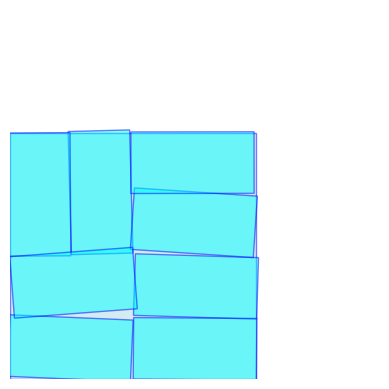

In [199]:
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()

In [210]:


def grad(best_solution):
    x = best_solution
    
    xt = torch.tensor(x, requires_grad=True)
    optimizer = torch.optim.Adam([xt], lr=0.001)
    for i in range(100):
        optimizer.zero_grad()
        f = torch_func(xt)
        f.backward()
        optimizer.step()
    return xt

def torch_func(x):
    return abs(x[0][0]) * abs(x[0][1]) * abs(torch.sin(x[0][2]))


def gradient_descent(func, initial_patterns, learning_rate=0.01, max_iters=300):
    patterns = list(initial_patterns)

    for _ in tqdm(range(max_iters)):
        gradient = grad(patterns)
        new_patterns = []
        for (x, y, phi), (gx, gy, gphi) in zip(patterns, gradient):
            new_x = np.clip(x - learning_rate * gx, min_bound[0], max_bound[0])
            new_y = np.clip(y - learning_rate * gy, min_bound[1], max_bound[1])
            new_phi = np.clip(phi - learning_rate * gphi, min_bound[2], max_bound[2])
            new_patterns.append((new_x, new_y, new_phi))

        patterns = new_patterns

    return tuple(patterns)


best_solution_after_ts = best_solution  

improved_solution = gradient_descent(func, best_solution_after_ts, learning_rate=0.01, max_iters=300)

print("Improved solution:", improved_solution)
print("Improved fitness:", func(improved_solution))


  0%|          | 0/300 [00:02<?, ?it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

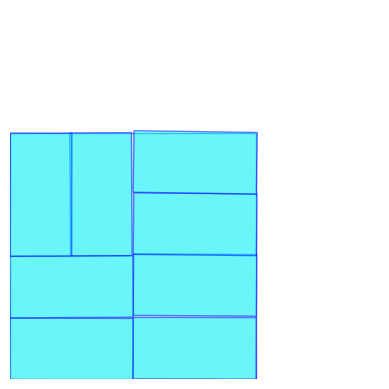

Улучшение 0.058439062301848546


In [207]:
# Визуализация
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in improved_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()
print ("Улучшение", func(best_solution)-func(improved_solution))
